# Case 2. Diabetic Retinopathy Analysis
Sanni Tolonen<br>
26.2.2018<br>
Cognitive Systems for Health Technology Applications, Spring 2018<br>
Helsinki Metropolia University of Applied Sciences

<h2>1. Objectives</h2><br>
The aim of this assignment is to learn to use convolutional neural networks to classify medical
images.<br>
For a little help in this assignment I checked what Ben Graham and his team had done in Kaggle Diabetic Retinopathy Detection competition report.

<h2> 2. Required libraries </h2>

In [1]:
# import libraries and functions

import numpy as np
import matplotlib.pyplot as plt 
import pickle
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import time

Using TensorFlow backend.


Numpy is used for scientific computing and creating multidimensional arrays, matplotlib for ploting figures, pickle for saving the history of the model, keras for building the convolutional neural network and time for calculating time.

<h2> 3. Data description and preprocessing </h2>

This dataset is a large set of high-resolution retina images taken under a variety of imaging conditions. 
A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4:

<ul>
<li>0 - No DR</li>
<li>1 - Mild</li>
<li>2 - Moderate</li>
<li>3 - Severe</li>
<li>4 - Proliferative DR</li>
</ul>

The images come from different models and types of cameras, which can affect the visual appearance. Some images are shown as one would see the retina anatomically meaning macula on the left, optic nerve on the right for the right eye. Others are shown as one would see through a microscope condensing lens in example inverted, as one sees in a typical live eye exam. There are two ways to tell if an image is inverted:

It is inverted if the macula, the small dark central area, is slightly higher than the midline through the optic nerve. If the macula is lower than the midline of the optic nerve, it's not inverted.
If there is a notch on the side of the image (square, triangle, or circle) then it's not inverted. If there is no notch, it's inverted.

In [2]:
# dataset directories and labels files

train_dir = "../dataset2/train" 
validation_dir = "../dataset2/validation" 
test_dir = "../dataset2/test" 

# create datagenerators

train_datagen = ImageDataGenerator(rescale=1./255,
                                   fill_mode='nearest',
                                   horizontal_flip=True,
                                   zoom_range=0.2)

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# training parameters

batch_size = 50
epochs = 50
steps_per_epoch = 25 
validation_steps = 10
image_height = 150
image_width = 200 

# generator for train dataset

print('Training dataset.')
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')

# generator for validation dataset

print('Validation dataset.')
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')

# generator for test dataset

print('Test dataset.')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')


Training dataset.
Found 1928 images belonging to 2 classes.
Validation dataset.
Found 1021 images belonging to 2 classes.
Test dataset.
Found 1013 images belonging to 2 classes.


Dataset is splitted to train, validation and test datasets. All images will be rescaled by 1./255 and resized to 150x200. Training set is supplemented. It's filling mode is choosed 'nearest' which means that if there are generated empty pixels in prosessing generator is able to choose a pixel value from nearest pixel that has a value. It's also accepting horizontal flip, zoom range is maxium in 20%. For preprocessing I first tried the preprocessing function designed by Sakari Lukkarinen but I had some issues with that so I did some research and used a different approach.

<h2> 4. Modeling and compilation </h2>

This model is almost exactly alike the one in Sakaris GitHub repository. I wanted to try with this one also, since I had problems with the other one. For starters, there is two Conv2D layers followed by one MaxPool2D layer. After two sets of these, there is two Conv2D layers and then two sets of two Conv2D layers with a Dropout layer for weight regularization to avoid overfitting. In the end there is  Flatten layer to flatten the input, a couple of Dense leyers and another Dropout layer.

In [3]:
# build the model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', 
                        input_shape = (image_height, image_width, 3)))
model.add(layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D((3, 3), strides=2))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D((3, 3), strides=2))

model.add(layers.Conv2D(96, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(96, (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D((3, 3), strides=2))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))

model.add(layers.Conv2D(160, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(160, (3, 3), activation = 'relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(192, (3, 3), activation = 'relu'))
model.add(layers.Conv2D(192, (3, 3), activation = 'relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

# compile the model

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 198, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 97, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 95, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 68, 93, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 33, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 44, 96)        55392     
__________

<h2> 5. Training and validation </h2>

In [4]:
# train the model

t1 = time.time()

h = model.fit_generator(
      train_generator,
      steps_per_epoch = steps_per_epoch,
      verbose = 1,
      epochs = epochs,
      validation_data = validation_generator,
      validation_steps = validation_steps)
t2 = time.time()

# store the elapsed time into history

h.history.update({'time_elapsed': t2 - t1})

# save the model and history

model.save('case_2_run_3.h5')
pickle.dump(h.history, open('case_2_history_3.p', 'wb'))

Epoch 1/50
25/25 [==============================] - 645s 26s/step - loss: 4.5573 - acc: 0.6998 - val_loss: 4.9644 - val_acc: 0.6920
Epoch 2/50
25/25 [==============================] - 578s 23s/step - loss: 4.7194 - acc: 0.7072 - val_loss: 4.9644 - val_acc: 0.6920
Epoch 3/50
25/25 [==============================] - 570s 23s/step - loss: 4.5941 - acc: 0.7150 - val_loss: 4.9644 - val_acc: 0.6920
Epoch 4/50
25/25 [==============================] - 613s 25s/step - loss: 4.6552 - acc: 0.7112 - val_loss: 4.9644 - val_acc: 0.6920
Epoch 5/50
25/25 [==============================] - 580s 23s/step - loss: 4.5131 - acc: 0.7200 - val_loss: 4.9644 - val_acc: 0.6920
Epoch 6/50
25/25 [==============================] - 555s 22s/step - loss: 4.7266 - acc: 0.7068 - val_loss: 4.9644 - val_acc: 0.6920
Epoch 7/50
25/25 [==============================] - 597s 24s/step - loss: 4.8390 - acc: 0.6998 - val_loss: 4.9644 - val_acc: 0.6920
Epoch 8/50
25/25 [==============================] - 571s 23s/step - loss: 4.

In [5]:
print('Time per epoch {:.2f} hours.'.format((t2-t1)/3600))
print('Time per epoch {:.2f} minutes.'.format((t2-t1)/40/60))

Time per epoch 8.19 hours.
Time per epoch 12.28 minutes.


<h2> 6. Evaluation </h2>

Here the model created above is tested with the testing set. 

In [6]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = (image_height, image_width),
        batch_size = batch_size,
        class_mode = 'binary')

r = model.evaluate_generator(test_generator, steps = 20)

# loss and accuracy
r

Found 1013 images belonging to 2 classes.


[4.6420114636421204, 0.71200000345706937]

<h2> 7. Results and discussion </h2>

Training accuracy is still under 0.75 the whole time. The final testing accuracy is 0.71. In the end of training the loss function is 4.77 which is really big. This means that the inconsistency between predicted value and actual label is large. The final testing loss function is 4.70. 

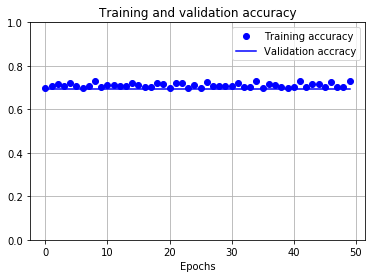

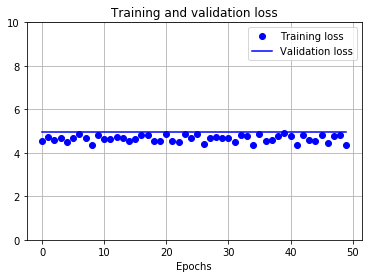

In [8]:
acc = h.history['acc']
val_acc = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accracy')
plt.title('Training and validation accuracy')
plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylim([0, 10])
plt.xlabel('Epochs')
plt.grid()
plt.legend()  

plt.show()

<h2>8. Conclusions</h2>

I had still the same problem, validation accuracy and validation loss stay the same and the results are even worse, I can not seem to understand what is going wrong.